In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

NVIDIA A100 80GB PCIe


In [3]:
from model import builder as model_builder
from attacker import builder as atk_builder

from utils.metric import AccuracyMetric


In [4]:
transform = T.Compose([
    # T.RandomCrop(32, padding=4, padding_mode="reflect"),
    # T.RandomHorizontalFlip(),
    T.ToTensor(),
])
train_set = CIFAR10(root="../../data", train=True, download=False, transform=transform)
test_set  = CIFAR10(root="../../data", train=False, download=False, transform=T.ToTensor())
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

images, labels = next(iter(test_loader))
images, labels  = images[:64].to(device), labels[:64].to(device)

In [117]:
shuffle = torch.randperm(64, device=device)
delta = PGD10(net, images, labels)

In [121]:
mask = delta.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1)
# mask = delta.sign()
mask = torch.where(mask < 8/255, 1.0, 0.0)
# mask = 1.0 - mask
# mask = torch.ones_like(images)
T.ToPILImage()(make_grid(mask * images + (1-mask) * images[shuffle])).resize((512, 512))

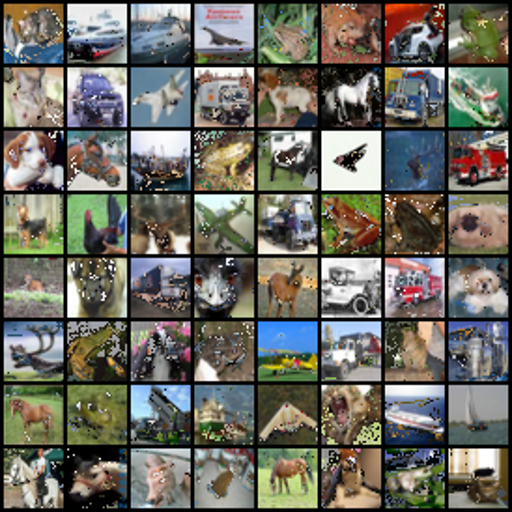

In [122]:
T.ToPILImage()(make_grid(mask * images + (1-mask) * images[shuffle])).resize((512, 512))

In [5]:
net = model_builder.build("resnet18", 10)
net.eval()
net = net.to(device)
PGD10 = atk_builder.build("PGD", steps=10, step_size=2/255, epsilon=8/255)
FGSM = atk_builder.build("PGD", steps=1, step_size=8/255, epsilon=8/255)

In [51]:
@torch.no_grad()
def test(model, dataloader, attack, thr):
    Nat = AccuracyMetric(10)
    Rob = AccuracyMetric(10)
    model.eval()
    for images, labels in tqdm(dataloader, disable=True):
        images, labels = images.to(device), labels.to(device)
        delta = attack(model, images, labels) if callable(attack) else torch.zeros_like(images)
        # mask = delta.sign()
        # mask[mask<=0.0] = 0.0
        # mask[mask>0.0]  = 1.0
        
        mask = torch.rand_like(images)
        mask = torch.where(mask > thr, 1.0, 0.0)

        # mask = torch.ones_like(images)
        # mask[... , :round(32*thr)] = 0.0
        # L = np.sqrt(round(32*32*thr))
        # L = int(L/2)
        # mask[..., 16-L:16+L, 16-L:16+L] = 0.0

        nat = model(mask * images)
        rob = model(mask * (images+delta))
        Nat.update(nat.detach().argmax(dim=-1).cpu().numpy(), labels.cpu().numpy())
        Rob.update(rob.detach().argmax(dim=-1).cpu().numpy(), labels.cpu().numpy())
    return Nat.item(), Rob.item()

In [105]:
@torch.no_grad()
def advmask(model, dataloader, attack, thr):
    Nat = AccuracyMetric(10)
    Rob = AccuracyMetric(10)
    model.eval()
    for images, labels in tqdm(dataloader, disable=True):
        images, labels = images.to(device), labels.to(device)
        delta = attack(model, images, labels) if callable(attack) else torch.zeros_like(images)
        mask = delta.sign()
        mask = torch.where(mask <= 0.0, 1.0, 0.0)
        # mask = torch.ones_like(images)
        nat = model(mask * images)
        rob = model(mask * (images+delta))
        Nat.update(nat.detach().argmax(dim=-1).cpu().numpy(), labels.cpu().numpy())
        Rob.update(rob.detach().argmax(dim=-1).cpu().numpy(), labels.cpu().numpy())
    return Nat.item(), Rob.item()

In [107]:
dataloader = test_loader
atk = PGD10
label1 = "PGDAT/best"
net.load_state_dict(torch.load(f"/home/t-renjiechen/workspace/results/resnet-18/{label1}.pth"))
advmask(net, dataloader, PGD10, 0.0)

(0.6871, 0.6865)

In [52]:
thrs = np.linspace(0, 1, 11)
dataloader = test_loader
atk = PGD10
label1 = "TRADES/last"
net.load_state_dict(torch.load(f"/home/t-renjiechen/workspace/results/resnet-18/{label1}.pth"))
nat1, rob1 = [], []

for thr in tqdm(thrs):
    nat, rob = test(net, dataloader, atk, thr)
    nat1.append(nat)
    rob1.append(rob)
label2 = "PGDAT/last"
net.load_state_dict(torch.load(f"/home/t-renjiechen/workspace/results/resnet-18/{label2}.pth"))

nat2, rob2 = [], []
for thr in tqdm(thrs):
    nat, rob = test(net, dataloader, atk, thr)
    nat2.append(nat)
    rob2.append(rob)

100%|██████████| 11/11 [02:03<00:00, 11.27s/it]


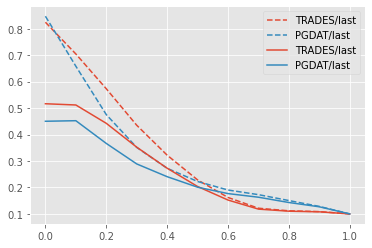

In [53]:
plt.plot(thrs, nat1, label=label1, color="C0", ls="--")
plt.plot(thrs, nat2, label=label2, color="C1", ls="--")
plt.plot(thrs, rob1, label=label1, color="C0")
plt.plot(thrs, rob2, label=label2, color="C1")
plt.legend()
plt.show()

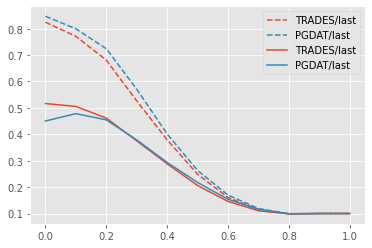

In [50]:
plt.plot(thrs, nat1, label=label1, color="C0", ls="--")
plt.plot(thrs, nat2, label=label2, color="C1", ls="--")
plt.plot(thrs, rob1, label=label1, color="C0")
plt.plot(thrs, rob2, label=label2, color="C1")
plt.legend()
plt.show()

In [54]:
# test(net, test_loader, PGD10)
test(net, test_loader, None)

100%|██████████| 79/79 [00:00<00:00, 89.05it/s] 


(0.2155, 0.2155)

In [5]:
@torch.no_grad()
def eval(model, dataloader, attack, thr):
    Acc = AccuracyMetric(10)
    Preds = []
    Labels = []
    model.eval()
    for images, labels in tqdm(dataloader, disable=True):
        images, labels = images.to(device), labels.to(device)

        out = model(images)
        Preds.append(F.softmax(out, dim=-1).cpu().numpy())
        Labels.append(labels.cpu().numpy())
        Acc.update(out.detach().argmax(dim=-1).cpu().numpy(), labels.cpu().numpy())
    print(Acc.item())
    return np.vstack(Preds), np.hstack(Labels)

In [120]:
# Expected Calibration Error(ECE) 期望标定误差

atk = None
label1 = "PGDAT/last"
net.load_state_dict(torch.load(f"/home/t-renjiechen/workspace/results/resnet-18/{label1}.pth"))

dataloader = train_loader
outputs, labels = eval(net, dataloader, None, 0.0)
# conf = outputs.max(axis=-1)
# pred = outputs.argmax(axis=-1)
prob = np.take_along_axis(outputs, labels.reshape(-1, 1), axis=-1).squeeze(axis=-1)
prob_train = prob
labels_train = labels

dataloader = test_loader
outputs, labels = eval(net, dataloader, None, 0.0)
prob = np.take_along_axis(outputs, labels.reshape(-1, 1), axis=-1).squeeze(axis=-1)
prob_test = prob
labels_test = labels

0.98914
0.8471


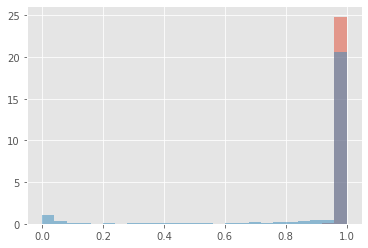

In [125]:
c = 9
plt.hist(prob_train[labels_train==c], bins=25, density=True, alpha=0.5, range=(0, 1))
plt.hist(prob_test[labels_test==c], bins=25, density=True, alpha=0.5, range=(0, 1))
plt.show()

In [103]:
# Expected Calibration Error(ECE) 期望标定误差
dataloader = train_loader
atk = None
label1 = "PGDAT/last"
net.load_state_dict(torch.load(f"/home/t-renjiechen/workspace/results/resnet-18/{label1}.pth"))

<All keys matched successfully>

In [104]:
outputs, labels = eval(net, dataloader, None, 0.0)

conf = outputs.max(axis=-1)
pred = outputs.argmax(axis=-1)
prob = np.take_along_axis(outputs, labels.reshape(-1, 1), axis=-1).squeeze(axis=-1)

correct = pred == labels

0.98868


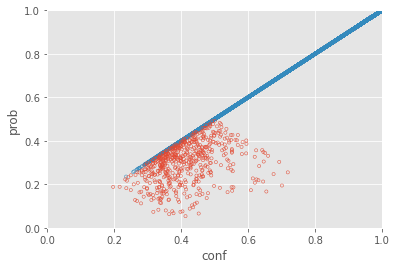

In [105]:
plt.scatter(conf[correct], prob[correct], s=10, c="none",marker='o',edgecolors='C1')
plt.scatter(conf[~correct], prob[~correct], s=10, c="none",marker='o',edgecolors='C0')
plt.xlabel("conf")
plt.ylabel("prob")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [106]:
bins = np.linspace(0.0, 1.0, 11)
inds = np.digitize(conf, bins)

In [108]:
Accs = []
for c in range(1, 11):
    m = inds == c
    acc = (pred[m] == labels[m]).sum() / max(m.sum(), 1)
    Accs.append(acc)

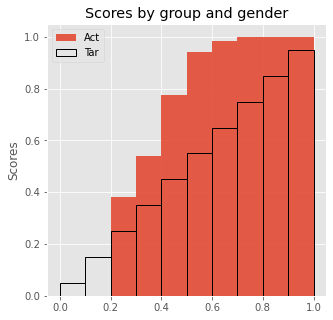

In [109]:
fig, ax = plt.subplots(figsize=(5, 5))
width = 0.1
x = bins[:10]
ax.bar(x, Accs, width, align="edge", label='Act', color="C0", alpha=0.9)
y = np.linspace(0.05, .95, 10)
ax.bar(x, y, width, align="edge", label='Tar', linewidth=1, edgecolor="black", color="C1", alpha=1.0, fill=False)
# ax.bar(x, gap, width, align="edge", label='Gap', bottom=y, color="C3", edgecolor="black", fill=False)

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

plt.show()

In [7]:
@torch.no_grad()
def eval(model, dataloader, attack, thr):
    Acc = AccuracyMetric(10)
    Preds = []
    Labels = []
    model.eval()
    for images, labels in tqdm(dataloader, disable=True):
        images, labels = images.to(device), labels.to(device)

        out = model(images)
        Preds.append(F.softmax(out, dim=-1).cpu().numpy())
        Labels.append(labels.cpu().numpy())
        Acc.update(out.detach().argmax(dim=-1).cpu().numpy(), labels.cpu().numpy())
    print(Acc.item())
    return Acc.item()

In [37]:
# bias

transform = T.Compose([
    # T.RandomCrop(32, padding=4, padding_mode="reflect"),
    # T.RandomHorizontalFlip(),
    # T.Grayscale(num_output_channels=3),
    # T.ColorJitter(brightness=[0.5, 2.0], contrast=[0.5, 2.0], saturation=[0.5, 2.0], hue=[-0.5, 0.5]),
    # T.RandomRotation(degrees=(-180, 180)),
    # T.RandomAffine(degrees=(-45, +45)),
    # translate=(0.1, 0.3), scale=(0.5, 1.5)
    T.RandomAffine(degrees=0, shear=(-0.5, 0.5, -0.5, 0.5)),
    T.ToTensor(),
])
train_set = CIFAR10(root="../../data", train=True, download=False, transform=transform)
test_set  = CIFAR10(root="../../data", train=False, download=False, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)


In [39]:
dataloader = train_loader
atk = None
label1 = "PGDAT/best"
net.load_state_dict(torch.load(f"/home/t-renjiechen/workspace/results/resnet-18/{label1}.pth"))

<All keys matched successfully>

# Color

transform | train | test
---|---|---
None |0.9915  | 0.8471
T.Grayscale(num_output_channels=3)| 0.9261|0.7743
T.ColorJitter(brightness=[0.2, 2.0])| 0.7553|0.6571
T.ColorJitter(contrast=[0.2, 2.0])|0.8576|0.7275
T.ColorJitter(saturation=[0.2, 2.0])|0.9858|0.8381
T.ColorJitter(hue=[-0.5, 0.5])|0.8990|0.7536

T.RandomAffine(degrees=0, translate=(0.0, 0.4))|0.82098|0.6932

In [40]:
acc = eval(net, train_loader, None, 0.0)
acc = eval(net, test_loader, None, 0.0)


0.87868
0.8236


Bad pipe message: %s [b'W\xd4\xa9{\x9eRTU{I#\xcc-\xb3\xe4\xe0\xf2\xd2 O\xb0\xd7\xb3\x84\xbb\xc1\x1fx\xafi\x01u\xf1?\x7f \xb9\xeb!@\x01h\x04Z\xa1\xf7\x94\xc9\x01cu\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08\x0b\x08\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06\x01\x00+\x00\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 +']
Bad pipe message: %s [b"J@\xe7\xd7\xab\x83ES\x8f\x8d\xc8\xef=Ld\xed\xab` s\xee \x8fz\x19\xf4\xbe\xde_\xbe{bB+'\xe0\xba\x1a\xaah\x1dm|'\xe4\xca\xc35\xab\xa26\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00"]
Bad pipe message: %s [b'\x0